In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os

## 1) Create functioning kmeans from Lloyds algorithm

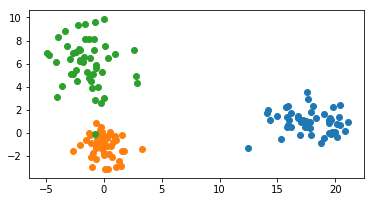

In [520]:
n = 50
d = 2

# Manually construct some 2d data
sigma1 = np.array([[2,0],[0,1]])
mu1 = np.array([[18],[1]])
x1 = sigma1@np.random.randn(2, n)+mu1

sigma2 = np.array([[1,0],[0,1]])
mu2 = np.array([[0],[-1]])
x2 = sigma2@np.random.randn(2, n)+mu2

sigma3 = np.array([[2,0],[0,2]])
mu3 = np.array([[-2],[6]])
x3 = sigma3@np.random.randn(2, n)+mu3

for xi in [x1,x2,x3]:
    plt.scatter(xi[0,:],xi[1,:])
plt.gca().set_aspect('equal')

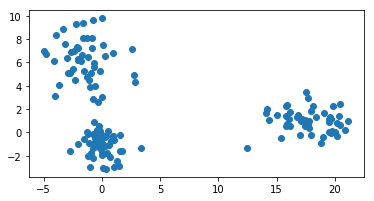

In [521]:
x = np.concatenate([x1,x2,x3], axis=1).T
x.shape
plt.scatter(x[:,0],x[:,1])
plt.gca().set_aspect('equal')

In [522]:
def classify_kmeans(x, k, epsilon, seed=None, init='k++'):
    '''
    Classify x in R^(n,d) into k groups according to Lloyd's algorithm.
    Exit condition is that new centers are maximally displaced by epsilon.
    @init: allowed options are 'k++', 'box'
    @k: must be >=1
    
    '''
    n,d = x.shape
    if seed:
        np.random.seed(seed)
        
    if init == 'box':
        bbox = np.array([np.min(x, axis=0), np.max(x, axis=0)]) # Initialize within data range.
        centers = np.random.rand(k,d)*(bbox[1]-bbox[0])+bbox[0]
    elif init == 'k++':
        indices = np.arange(n)
        centers = x[np.random.choice(indices),:].reshape(1,d)
        for i in range(k-1):
            distances = np.array([np.sum(np.square(xi-centers), axis=1) for xi in x])
            weights = np.min(distances, axis=1)
            weights = weights/np.sum(weights)
            centers = np.append(centers, x[np.random.choice(indices, p=weights),:].reshape(1,d), axis=0)
    else:
        print('Unknown initialization scheme {}'.format(init))
        return None, None, None

    objective = []
    condition = True
    while condition:
        distances = np.array([np.sum(np.square(xi-centers), axis=1)  for xi in x])
        classify = np.argmin(distances, axis=1)
        objective.append(np.sum([np.sum(distances[classify==c, c])/np.sum(classify==c)
                                 if np.any(classify==c) else 0 for c in range(k)]))
        # If no points in class, reuse old center
        new_centers = np.array([np.mean(x[classify==c], axis=0) if np.any(classify==c)
                                else centers[c] for c in range(k)])
        if np.max(np.sum(np.square(new_centers - centers), axis=1)) < epsilon:
            condition = False
        centers = np.copy(new_centers)
    return classify, centers, objective

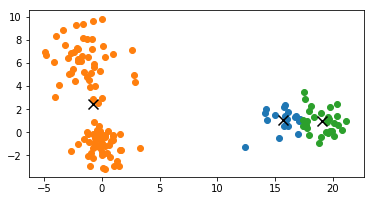

In [527]:
classes, centers, obj = classify_kmeans(x, k=3, init='box', epsilon=1e-2, seed=3)
for c in np.unique(classes):
    cut = classes==c
    plt.scatter(x[cut,0],x[cut,1])
plt.scatter(centers[:,0], centers[:,1], c='k', marker='x', s=100)
plt.gca().set_aspect('equal')

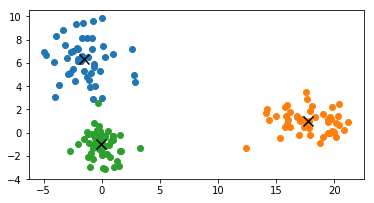

In [528]:
classes, centers, obj = classify_kmeans(x, k=3, init='k++', epsilon=1e-2, seed=3)
for c in np.unique(classes):
    cut = classes==c
    plt.scatter(x[cut,0],x[cut,1])
plt.scatter(centers[:,0], centers[:,1], c='k', marker='x', s=100)
plt.gca().set_aspect('equal')

## 2) Apply kmeans to MNIST dataset

In [247]:
from mnist import MNIST

In [249]:
mndata = MNIST(r'../CSE-546-HW-1/data/')
X_train, labels_train = map(np.array, mndata.load_training())
X_test, labels_test = map(np.array, mndata.load_testing())
X_train = X_train/255.0
X_test = X_test/255.0

In [410]:
import warnings

In [412]:
def clean_ax(ax):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off',
                       right='off', left='off', labelleft='off')

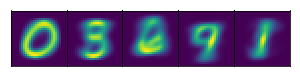

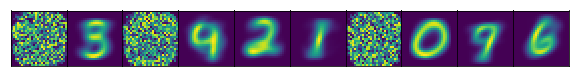

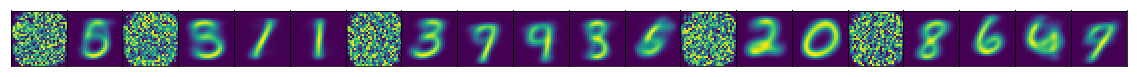

In [449]:
all_classes = []
all_centers = []
all_objectives = []
for k in [5,10,20]:
    kclasses, kcenters, kobj = classify_kmeans(X_train, k, epsilon=1e-1, seed=1, init='box')
    all_classes.append(kclasses)
    all_centers.append(kcenters)
    all_objectives.append(kobj)
    fig, ax = plt.subplots(1, k, figsize=[k,10])
    for c, anAx in zip(kcenters, ax):
        anAx.imshow(c.reshape([28,28]))
        clean_ax(anAx)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(os.path.join(r'./figs','imshow_seed{}_{}.pdf'.format(1, k)))

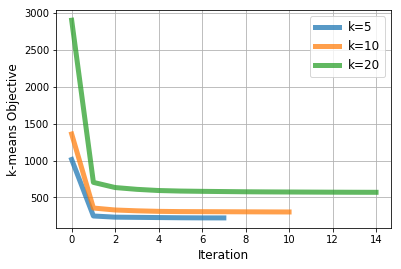

In [455]:
for obj in all_objectives:
    plt.plot(np.arange(len(obj)), obj, lw=5, alpha=0.75)
#     plt.yscale('log')
    plt.xlabel('Iteration', fontsize = 12)
    plt.ylabel('k-means Objective', fontsize=12)
plt.legend(['k=5','k=10','k=20'],fontsize=12)
plt.grid(True)
plt.savefig(os.path.join(r'./figs','kmeans_objs.pdf'))

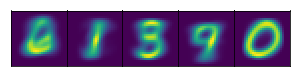

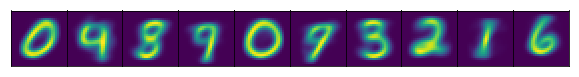

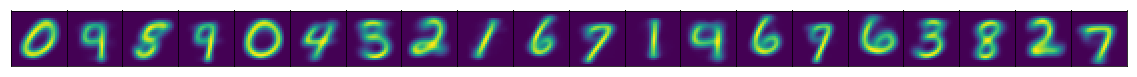

In [486]:
all_classes_2 = []
all_centers_2 = []
all_objectives_2 = []
for k in [5,10,20]:
    kclasses, kcenters, kobj = classify_kmeans(X_train, k, epsilon=1e-1, seed=1, init='k++')
    all_classes_2.append(kclasses)
    all_centers_2.append(kcenters)
    all_objectives_2.append(kobj)
    fig, ax = plt.subplots(1, k, figsize=[k,10])
    for c, anAx in zip(kcenters, ax):
        anAx.imshow(c.reshape([28,28]))
        clean_ax(anAx)
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.savefig(os.path.join(r'./figs','imshow_kpp_seed{}_{}.pdf'.format(1, k)))

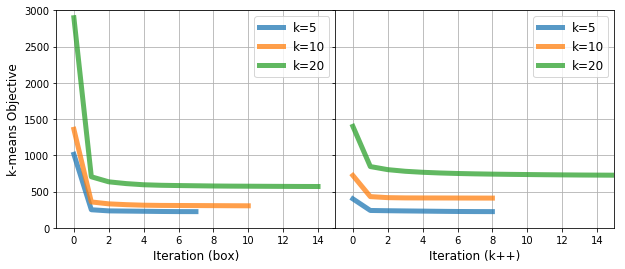

In [530]:
fig, ax = plt.subplots(1,2, figsize=[10,4])

for obj in all_objectives:
    ax[0].plot(np.arange(len(obj)), obj, lw=5, alpha=0.75)
    ax[0].set_xlabel('Iteration (box)', fontsize = 12)
    ax[0].set_ylabel('k-means Objective', fontsize=12)
ax[0].legend(['k=5','k=10','k=20'],fontsize=12)
ax[0].grid(True)

for obj in all_objectives_2:
    ax[1].plot(np.arange(len(obj)), obj, lw=5, alpha=0.75)
    ax[1].set_xlabel('Iteration (k++)', fontsize = 12)
    ax[1].set_yticklabels([])
ax[1].legend(['k=5','k=10','k=20'],fontsize=12)
ax[1].grid(True)

for iax in ax:
    iax.set_ylim([0,3000])
    iax.set_xlim([-1,15])

fig.subplots_adjust(wspace=0)
    
fig.savefig(os.path.join(r'./figs','kmeans_combo_objs.pdf'))